# Introduction

* Here, we will do investigation to check if there is any further scope of improvement of the model.
* Understand the behavior of data.
* Check the behavior of the model on various datapoints. In other words, check the model's performance on different sets of data and see why the model performs good on some datapoints and does not perform well on other datapoints.
* Identify the future scope of how the model(s) can be further optimized to give better performance result.

# 1. Import Libraries

In [1]:
import warnings
import pickle
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from sklearn.metrics import log_loss, confusion_matrix
from tensorflow.keras import models, backend
from tensorflow.keras.losses import binary_crossentropy

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

In [4]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


----

# 2. Utility Function

* We will create some utility functions that can be reused to plot various graphs.

In [5]:
def generateWordCloud(figsize, data, case):
    '''
    Function to generate the Word Cloud of the comments text in toxic and non-toxic class, and various toxicity subgroups.
    
    Parameters:
    ----------
    figsize: tuple
        width and height of the figure.
    data: pandas.core.frame.DataFrame
        DataFrame containing the comment texts.
    case: str
        Value to signify whether it's a case of best case or worst case
    '''
    
    # Get the list of stop words from the nltk.corpus library
    stop_words = stopwords.words('english')
    
    # Join all the comment texts
    text = ' '.join(text for text in data['comment_text'])
    
    # Create and generate a Word Cloud image
    wc = WordCloud(background_color='white', max_words=len(text), stopwords=stop_words)
    wc.generate(text)
    
    plt.figure(figsize=figsize) # Figure size of the Plot
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    plt.title('Word Cloud of the words used in {} case'.format(case), fontsize=30, color=sns.color_palette('muted')[0], fontweight='bold')
    plt.show()

In [6]:
def plotNumFeature(**kwargs):
    '''
    Function to plot different kinds of plot for the numeric features like Density Plot (Histogram/PDF) or
    BoxPlot using seaborn.
    
    Parameters
    ----------
    **kwargs: Keyword Arguments
    '''
    
    sns.set_style('whitegrid') # Set the backgound of the plot as 'whitegrid'
    
    # If Density (Histogram/PDF) Plot is required to be shown.
    if (kwargs['type'] == 'Density'):
        
        # If hue is required to separate the plot based on the class label
        if 'hue' in kwargs.keys():
            
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight'], hue=kwargs['hue']) \
                .map(sns.distplot, kwargs['feature']) # Plot the Density Plot with hue based on class label.
            plt.legend(['Non-toxic', 'Toxic']) # Add legends
            
        else:
            
            # Plot the Density Plot without a hue based on class label.
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight']).map(sns.distplot, kwargs['feature'])

    plt.title(kwargs['title'], fontsize=20) # Title of the plot.
    plt.xlabel(kwargs['xlabel'], fontsize=15) # Label on the x-axis.
    plt.ylabel(kwargs['ylabel'], fontsize=15) # Label on the y-axis.
    plt.show() # Show the plot.

In [7]:
def plotPerformanceMatrix(yActual, yPred):
    '''
    Function to compute Confusion, Precision and Recall Matrix and plot them.
    
    Parameters:
    ----------
    yActual: array-like
        Ground truth (correct) class labels for 'n' samples.
    yPred: array-like
        Predicted class labels for 'n' samples.
    '''
    
    # Get Confusion Matrix based on the input 'yActual' and 'yPred'.
    confusionMatrix = confusion_matrix(y_true=yActual, y_pred=yPred)
    
    # Compute the Precision Matrix
    precisionMatrix = (confusionMatrix/confusionMatrix.sum(axis=0))
    # Divide each element of the confusion matrix with the sum of the elements in that column (total predicted value)
    
    # Compute the Recall Matrix
    recallMatrix = (confusionMatrix.T/confusionMatrix.sum(axis=1)).T
    # Divide each element of the confusion matrix with the sum of the elements in that row (total actual values)
    
    plt.figure(figsize=(20,5))
    
    # Plot the Confusion Matrix.
    plt.subplot(131)
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.ylabel('Actual Values', fontsize=15) # Label on the y-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-toxic)', 'Predicted: YES (Toxic)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Actual: NO (Non-toxic)', 'Actual: YES (Toxic)'], rotation=0)
    
    # Plot the Precision Matrix.
    plt.subplot(132)
    sns.heatmap(precisionMatrix, annot=True, fmt='.3f', cmap=sns.light_palette('green'))
    plt.title('Precision Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-toxic)', 'Predicted: YES (Toxic)'])
    
    # Plot the Recall Matrix.
    plt.subplot(133)
    sns.heatmap(recallMatrix, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Recall Matrix on Test Data', fontsize=20)
    plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-toxic)', 'Predicted: YES (Toxic)'])
    plt.show()

----

# 3. Evaluation

## 3.1. Get the data required for Model Evaluation

* Fetch the data in the required format for evaluating the model.
* The required data was saved in the pickle file during the baseline modeling.

In [8]:
%%time
# Read the required data from the pickle file.
#variablesPicklePath = 'Resources/finalVariables.pkl' # Variable containing the path of the pickle file.
variablesPicklePath = F'/content/gdrive/My Drive/Case Study 2/finalVariables.pkl' # Google Drive location    
with open(variablesPicklePath, 'rb') as f:
        
    # Read all the processed variables.
    xTrainText, xTrainNum, yTrainW, yTrainAux, xCVText, xCVNum, yCVW, yCVAux, xTestText, xTestNum, yTestW, yTestAux, \
    testData, embeddingMatrix, lossWeight, vocabSize, maxSeqLength, gloveVectorDim, identitySubgroups, auxColumns = pickle.load(f)

CPU times: user 1.44 s, sys: 5.24 s, total: 6.68 s
Wall time: 7.65 s


In [9]:
print('Test Data: Text Embedded Features Shape: ', xTestText.shape)

Test Data: Text Embedded Features Shape:  (230122, 210)


In [10]:
# Display top 5 records from the Test Dataset
testData.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text1,original_text_wc,preprocessed_text_wc1
755014,5044839,1,"oh left wing stupidity never ends, you know it...",0.018868,0.018868,0.056604,0.660377,0.018868,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-03-23 18:10:01.104733+00,54,5044572.0,321633,approved,0,0,0,1,1,0.0,0,53,oh left wing stupidity never ends you know its...,18,18
829374,5135836,0,They have no interest in those of lesser means...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-04-15 12:11:27.202073+00,54,5133988.0,326995,approved,1,0,0,0,4,0.0,0,4,they have no interest in those of lesser means...,26,27
663613,1053903,0,"hurts, don't it?",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-02-28 00:41:40.586616+00,21,1052155.0,315248,rejected,0,0,0,0,0,0.0,0,4,hurts do not it ?,3,5
1507984,5966577,0,""" Why do the NeoComs want illegal aliens prote...",0.000000,0.000000,0.000000,0.100000,0.000000,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-09-16 22:02:23.972802+00,102,5963226.0,378326,approved,0,0,0,0,2,0.0,0,10,why do the neocoms want illegal aliens protec...,26,27
888383,5207232,0,"fair enough, but then EVERY outrage outbreak o...",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-05-02 23:40:51.890084+00,54,NaN,331453,approved,0,0,1,12,3,0.0,0,4,fair enough but then every outrage outbreak on...,23,26


## 3.2. Load the Pre-trained Model

### 3.2.1. Custom Loss Function

* Define the custom loss function used while training the model during the training phase.
* This custom function has to be defined and passed in the custom object configuration while loading the pre-trained model.

In [11]:
# Reference: https://github.com/nidhibansal1902/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Jigsaw-LSTM%20with%20Glove%20Embedding%20New.ipynb
def customLoss(yActual, yPred):
    '''
    Function to calculate loss for the toxic class label.
    
    Parameters:
    -----------
    yActual: array-like
        Actual Class Labels.
    yPred: array-like
        Predicted Class Labels.
    '''
    
    return binary_crossentropy(backend.reshape(yActual[:, 0], (-1, 1)), yPred) * yActual[:, 1]

In [12]:
%%time
# Load the pre-trained best model for doing prediction.
#model = models.load_model('BestModels/modelBiLSTM.h5')
model = models.load_model(F'/content/gdrive/My Drive/Case Study 2/BestModels/modelBiLSTM.h5', custom_objects={'customLoss': customLoss})

CPU times: user 2.17 s, sys: 1.28 s, total: 3.45 s
Wall time: 3.69 s


## 3.2. Prediction

* Predict the Toxicity Score (Probability) for the comment texts in the test dataset.

In [13]:
%%time
# Predict the Probabilities of the class label of the Test Dataset and store it in a new feature 'yPredProb' of the Test Dataset.
testData['yPredProb'] = model.predict(xTestText)[0].flatten()

CPU times: user 2min 52s, sys: 11.7 s, total: 3min 3s
Wall time: 2min 33s


In [14]:
%%time
# Create a new feature called 'yPred' to indicate the class label and not the probability.
# If the Probability is greater than or equal to 0.5, the class label will be 1, otherwise 0.
testData['yPred'] = testData['yPredProb'].apply(lambda x: 1 if x >= 0.5 else 0)

CPU times: user 86.2 ms, sys: 3.75 ms, total: 89.9 ms
Wall time: 86.4 ms


In [15]:
# Display top 5 records from the Test Dataset
testData[['id', 'comment_text', 'target', 'yPredProb', 'yPred']].head()

,id,comment_text,target,yPredProb,yPred
755014,5044839,"oh left wing stupidity never ends, you know it...",1,0.995426,1
829374,5135836,They have no interest in those of lesser means...,0,0.005457,0
663613,1053903,"hurts, don't it?",0,0.004673,0
1507984,5966577,""" Why do the NeoComs want illegal aliens prote...",0,0.099142,0
888383,5207232,"fair enough, but then EVERY outrage outbreak o...",0,0.067499,0


----

# 4. Post Training Analysis

* Now, we will do some post training analysis on the trained model to see how the model is performing well on some data points and not so well on other data points.

## 4.1. Split the dataset based on their best, worst and medium scores of the predicted probability estimates

* Considering,<br>
&emsp; i. Best case for the toxic comments (target = 1) having probability estimates greater than 80% and non-toxic comments (target = 0) having probability estimates less than 20%.<br>
&emsp; ii. Worst case for the toxic comments (target = 1) having probability estimates less than 20% and non-toxic comment (target = 0) having probability estimates greater than 80%.

In [16]:
%%time
bestCondition = ((testData['target'] == 1) & (testData['yPredProb'] >= 0.8)) | ((testData['target'] == 0) & (testData['yPredProb'] <= 0.2))
worstCondition = ((testData['target'] == 1) & (testData['yPredProb'] <= 0.2)) | ((testData['target'] == 0) & (testData['yPredProb'] >= 0.8))

CPU times: user 4.5 ms, sys: 1.09 ms, total: 5.59 ms
Wall time: 5.17 ms


In [17]:
# Filter the dataset based on the best, medium and worst case.
bestData = testData[bestCondition]
worstData = testData[worstCondition]
mediumData = testData[(~bestCondition) & (~worstCondition)]

In [18]:
print('Number of data points in the best case: ', bestData.shape[0])
print('Number of data points in the worst case: ', worstData.shape[0])
print('Number of data points in the medium case: ', mediumData.shape[0])
print('Total number of data points: ', testData.shape[0])

Number of data points in the best case:  204323
Number of data points in the worst case:  4417
Number of data points in the medium case:  21382
Total number of data points:  230122


### Observation

* Out of the total 230122 data points, there are:<br>
&emsp; i. 204323 data points with best scores.<br>
&emsp; i. 4417 data points with worst scores.<br>
&emsp; i. 21382 data points with medium scores.<br>

## 4.2. Word Cloud

* Plot the word cloud of all the words in the comment text from best and worst scored data points.

### 4.2.1 Word Cloud of the words from best case dataset

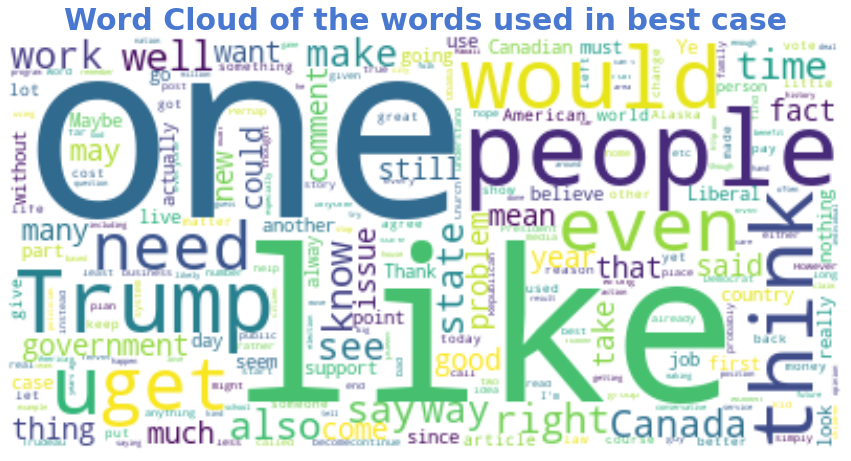

CPU times: user 44.8 s, sys: 1.29 s, total: 46.1 s
Wall time: 45.9 s


In [19]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for the words in the best dataset.
generateWordCloud(figsize=(15, 8), data=bestData, case='best')

### Observation from the word cloud of best case dataset

* Words like 'like', 'one', 'like', 'Trump', 'people' etc. are the most often used words in the dataset having best scores.

### 4.2.2 Word Cloud of the words from worst case dataset

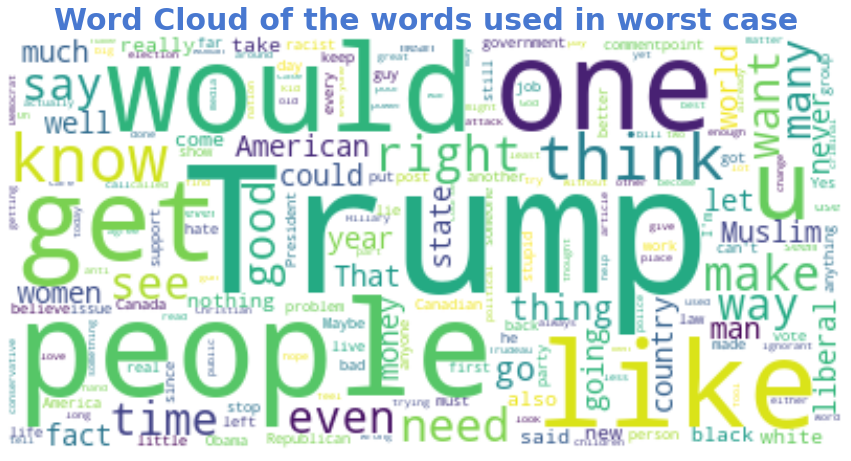

CPU times: user 1.82 s, sys: 53.6 ms, total: 1.87 s
Wall time: 1.86 s


In [20]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for the words in the worst dataset.
generateWordCloud(figsize=(15, 8), data=worstData, case='worst')

### Observation from the word cloud of worst case dataset

* Words like 'Trump', 'would', 'people', 'like', 'one' etc. are the most often used words in the dataset having worst scores.
<br>

* As we see there are some common words like 'one', 'people', 'Trump', 'like', etc. in both the comments from best and worst datasets, we cannot draw anything concrete from the word clouds.

## 4.3. Plot the distribution of comments' length

* Plot the distribution of the length of the comments in the comment text from best and worst scored data points.

In [21]:
%%time
# Create a new feature 'comment_length' to signify the length of comment i.e., number of words in the comments.
bestData['comment_length'] = bestData['comment_text'].apply(lambda x: len(x.split()))
worstData['comment_length'] = worstData['comment_text'].apply(lambda x: len(x.split()))

CPU times: user 633 ms, sys: 849 µs, total: 634 ms
Wall time: 630 ms


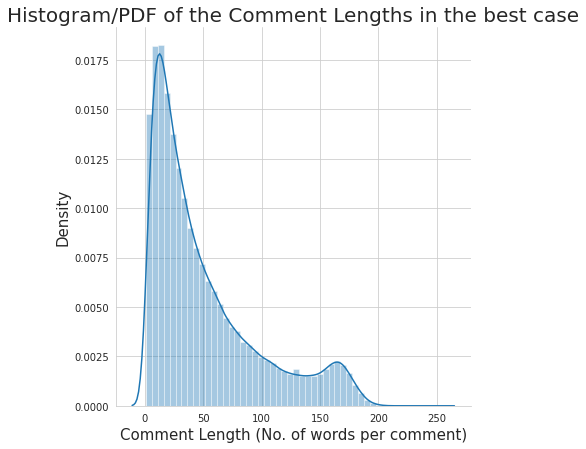

CPU times: user 2.42 s, sys: 742 ms, total: 3.16 s
Wall time: 2.44 s


In [22]:
%%time
# Call the function 'plotNumFeature()' to display the PDF of the comment length for both toxic and non-toxic class in the best dataset.
plotNumFeature(type='Density', data=bestData, feature='comment_length', figureHeight=6,
               title='Histogram/PDF of the Comment Lengths in the best case', 
               xlabel='Comment Length (No. of words per comment)', ylabel='Density')

### Observation from the Histogram/PDF of the Comment Lengths in the best case

* Maximum length of comments is around 200.
* There are very few datapoints with comments having length more than 200.
* Most of the comments have length between 10 and 20.

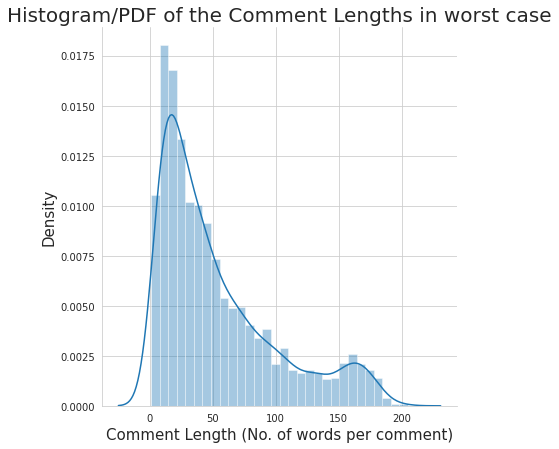

CPU times: user 713 ms, sys: 229 ms, total: 943 ms
Wall time: 692 ms


In [23]:
%%time
# Call the function 'plotNumFeature()' to display the PDF of the comment length for both toxic and non-toxic class in the worst dataset.
plotNumFeature(type='Density', data=worstData, feature='comment_length', figureHeight=6,
               title='Histogram/PDF of the Comment Lengths in worst case', 
               xlabel='Comment Length (No. of words per comment)', ylabel='Density')

### Observation from the Histogram/PDF of the Comment Lengths in the worst case

* Maximum length of comments is around 200.
* There are very few datapoints with comments having length more than 200.
* Most of the comments have length between 15-20.
<br>

* There is no key differentiator between the plots of best and worst except the maximum number of comments having 10-20 length in best case and 15-20 length in worst case.

## 4.4. Plot the Confusion, Recall and Precision Matrix

* Plot the Confusion Matrix from the predicted scores of the model for the complete test dataset.

## 4.4.1. Confusion, Recall and Precision Matrix of the Complete Dataset

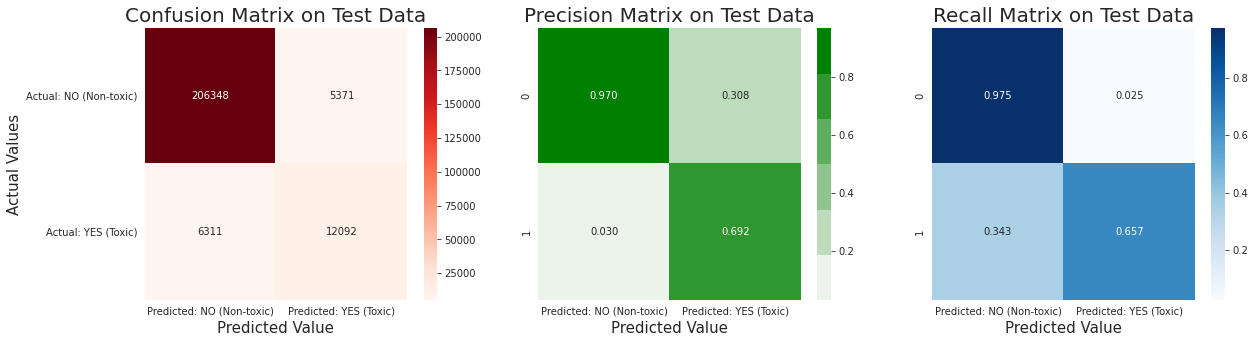

CPU times: user 791 ms, sys: 237 ms, total: 1.03 s
Wall time: 775 ms


In [24]:
%%time
# Call the function 'plotPerformanceMatrix()' to show the Performance Matrix for the complete test dataset.
plotPerformanceMatrix(yActual=testData['target'], yPred=testData['yPred'])

### Observation from the above matrix

* From the above plot, we can observe the below values:<br>
&emsp; i. False Positive = 5371<br>
&emsp; ii. False Negative = 6311<br>
&emsp; iii. Precision = 69.2%<br>
&emsp; iv. Recall = 65.7%<br>
* The above values are high but should have been low.

<br>

* Let's plot the matrix for the best, medium and worst case dataset separately and see which the values.

## 4.4.2. Confusion, Recall and Precision Matrix of the Best scored Dataset

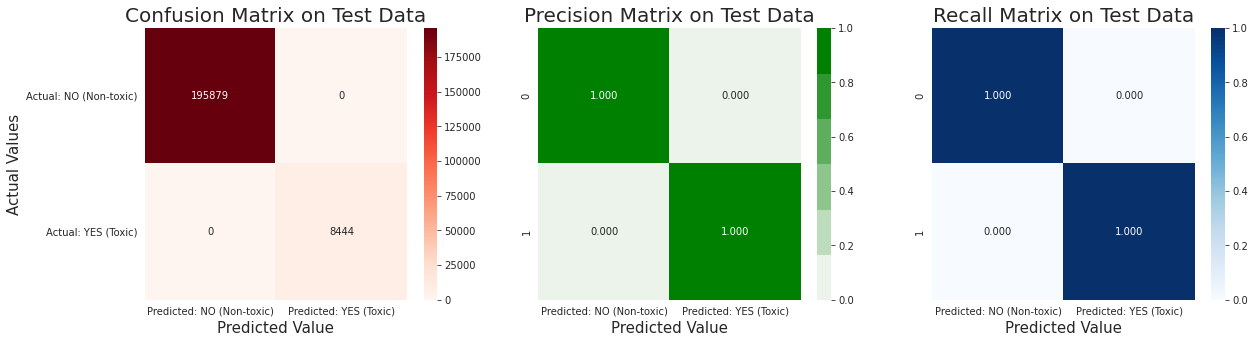

CPU times: user 801 ms, sys: 250 ms, total: 1.05 s
Wall time: 789 ms


In [25]:
%%time
# Call the function 'plotPerformanceMatrix()' to show the Performance Matrix for the best dataset.
plotPerformanceMatrix(yActual=bestData['target'], yPred=bestData['yPred'])

### Observation from the Performance Matrix of the best scored dataset

* From the above matrix for best case dataset, we can see that there is no False Positive or False Negative case.
* Also, the Precision and Recall values are having maximum value of 1.
* This implies that the model has performed exceptionally well for the best score data

## 4.4.3. Confusion, Recall and Precision Matrix of the Medium scored Dataset

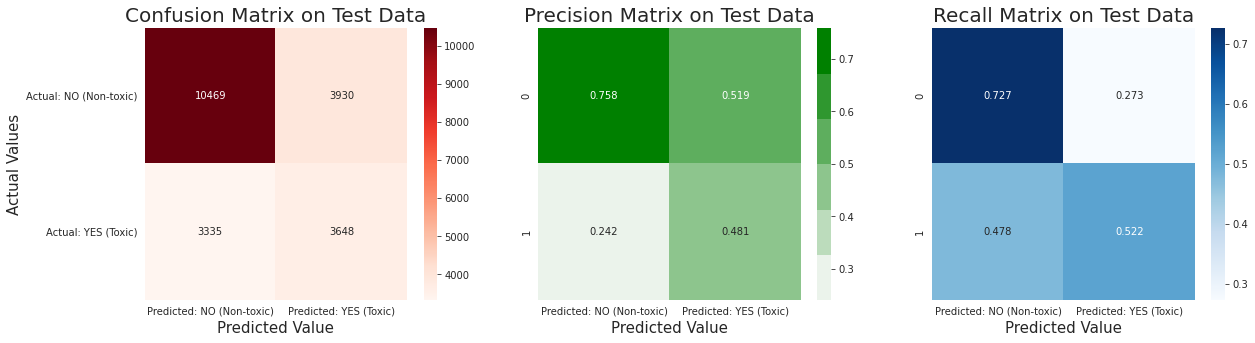

CPU times: user 737 ms, sys: 237 ms, total: 974 ms
Wall time: 718 ms


In [26]:
%%time
# Call the function 'plotPerformanceMatrix()' to show the Performance Matrix for the medium scored dataset.
plotPerformanceMatrix(yActual=mediumData['target'], yPred=mediumData['yPred'])

### Observation from the Performance Matrix of the medium scored dataset

* From the above plot, we can observe the below values:<br>
&emsp; i. False Positive = 3930<br>
&emsp; ii. False Negative = 3335<br>
&emsp; iii. Precision = 48.1%<br>
&emsp; iv. Recall = 52.2%<br>

* The Model has deteoriated here.
* Let's check the performance matrix for the worst scored dataset.

## 4.4.4. Confusion, Recall and Precision Matrix of the Worst scored Dataset

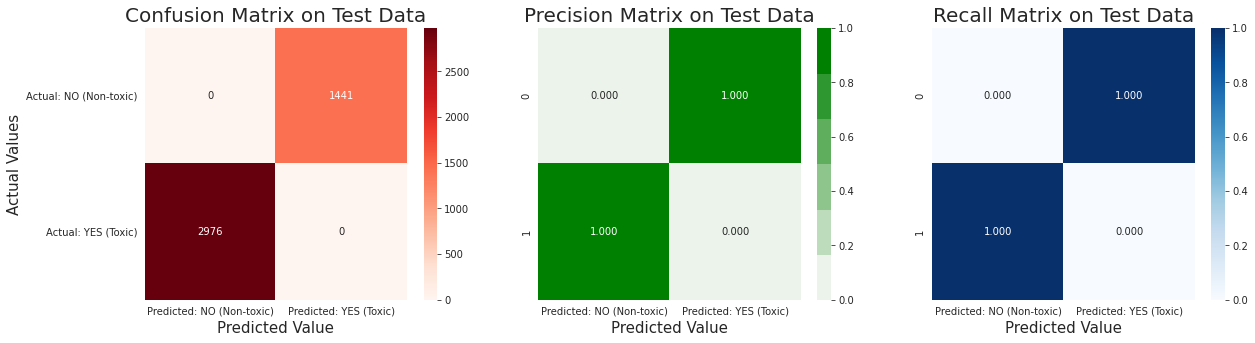

CPU times: user 709 ms, sys: 224 ms, total: 934 ms
Wall time: 689 ms


In [27]:
%%time
# Call the function 'plotPerformanceMatrix()' to show the Performance Matrix for the worst dataset.
plotPerformanceMatrix(yActual=worstData['target'], yPred=worstData['yPred'])

### Observation from the Performance Matrix of the worst scored dataset

* From the above plot, we can observe the below values:<br>
&emsp; i. False Positive = 1441<br>
&emsp; ii. False Negative = 2976<br>
&emsp; iii. Precision = 0%<br>
&emsp; iv. Recall = 0%<br>

* The Model has performed the worst for the worst score dataset

<br>


* We can try the below options to improve the performance metric scores:<br>
&emsp; i. Identify the outliers and handle them.<br>
&emsp; ii. We can try to improve the data quality of the dataset by doing better data cleaning and pre-processing.<br>
&emsp; iii. We can try building a more complex model and see the performance.<br>
&emsp; iv. Do better featurization. I had tried BERT features followed by MLP but it didn't give better performance than the Bi-directional LSTM Model (final model). We could try doing fine-tuning of BERT and build the model.<br>


## 4.5. Word Cloud of False Negative and False Positive datapoints

* Plot the Word Cloud of False Negative and False Positive datapoints from the complete test dataset and not from the best, medium or worst datasets.

In [28]:
%%time
# Condition for False Negative.
falseNegativeCondition = ((testData['target'] == 1) & (testData['yPred'] == 0)) # Actual Positive but Predicted Negative.

# Condition for False Positive.
falsePositiveCondition = ((testData['target'] == 0) & (testData['yPred'] == 1)) # Actual Negative but Predicted Positive.

CPU times: user 4.28 ms, sys: 110 µs, total: 4.39 ms
Wall time: 3.56 ms


In [29]:
%%time
# Filter the dataset based on the False Negative and False Positive.
falseNegativeData = testData[falseNegativeCondition]
falsePositiveData = testData[falsePositiveCondition]

CPU times: user 15.3 ms, sys: 1.01 ms, total: 16.3 ms
Wall time: 15.5 ms


In [30]:
print('Number of data points in the False Nagative case: ', falseNegativeData.shape[0])
print('Number of data points in the False Positive case: ', falsePositiveData.shape[0])

Number of data points in the False Nagative case:  6311
Number of data points in the False Positive case:  5371


### 4.5.1. Word Cloud

* Plot the word cloud of all the words in the comment text from False Negative and False Positive data points.

#### 4.5.1. Word Cloud of False Negative dataset

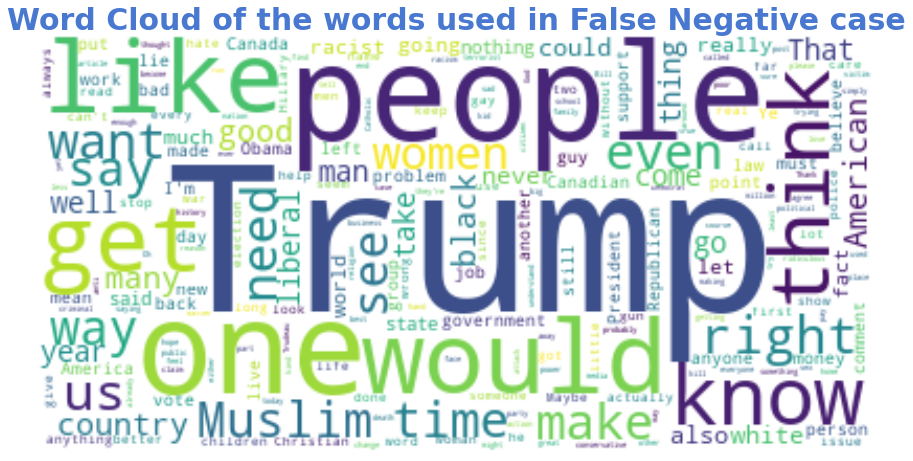

CPU times: user 2.54 s, sys: 92.8 ms, total: 2.63 s
Wall time: 2.61 s


In [31]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for the words in the False Negative dataset.
generateWordCloud(figsize=(15, 8), data=falseNegativeData, case='False Negative')

### Observation from the word cloud of False Negative dataset

* Words like 'Trump', 'one', 'people', 'like', 'get' etc. are the most often used words in the dataset having False Negative points.
<br>

#### 4.5.2. Word Cloud of False Positive dataset

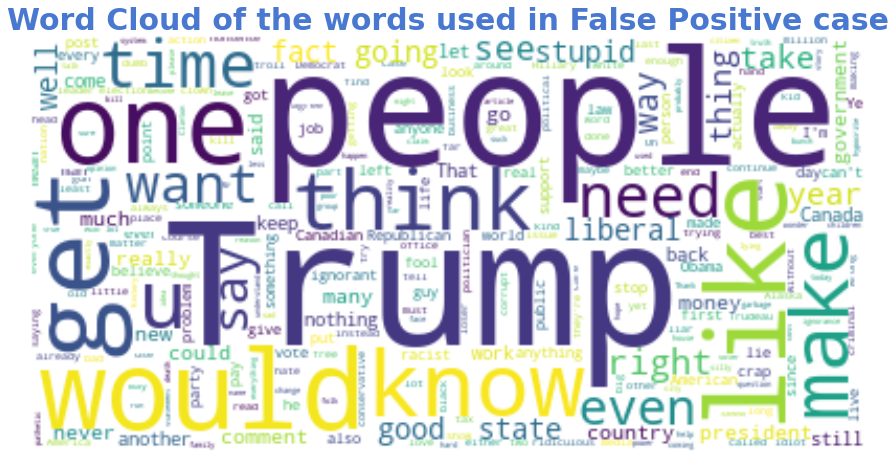

CPU times: user 2.38 s, sys: 55.9 ms, total: 2.43 s
Wall time: 2.42 s


In [32]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for the words in the False Positive dataset.
generateWordCloud(figsize=(15, 8), data=falsePositiveData, case='False Positive')

### Observation from the word cloud of False Positive dataset

* Words like 'Trump', 'would', 'people', 'one', 'like' etc. are the most often used words in the dataset having False Positive points as well.

<br>

* The most often used words are same for both False Negative and False Positive Datasets.


### Future Scope of Improvement

* We can try the below options to improve the performance of the model further:<br>

#### 1. Data Centric Approach

* We can perform better data cleaning and try to improve the quality of data. We can perform the below operations:<br>
&emsp; i. Identify the outliers and handle them.<br>
&emsp; ii. Do better featurization. We can try better contextual featurization techniques like BERT and fine-tuning to reduce the False Negatives and False Positives. I had tried BERT features followed by MLP but it didn't give better performance than the Bi-directional LSTM Model (final model). Hence, fine-tuning of BERT would be required.<br>
&emsp; iii. We can try to improve the data quality of the dataset by doing better data cleaning and pre-processing by doing more research on the domain or reaching out to the Domain Experts.<br>

#### 2. Model Centric Approach

* After the data cleaning is done, we can:<br>
&emsp; i. Perform fine-tuning of BERT (computationally expensive) and build the model.<br>
&emsp; ii. Build a more complex model and see the performance.<br>

----